In [17]:
import pandas as pd
df = pd.read_csv("final_data.csv")
df.head(10)

,Unnamed: 0,gvkey,fyear,company.name,tic,sbf,kld_index,kld_governance,kld_community,kld_diversity,...,gsector,ggroup,gind,gsubind,sic,cik,cusip,dualclass,average_current_RRI,research.and.development
0,24,1004,2003,AAR CORP,AIR,1,0.000000,0.0,0.0,0.000000,...,20,2010,201010,20101010,5080,1750.0,00036110,0.0,NaN,NaN
1,25,1004,2004,AAR CORP,AIR,1,-0.533333,0.0,0.0,-0.333333,...,20,2010,201010,20101010,5080,1750.0,00036110,0.0,NaN,NaN
2,34,1004,2013,AAR CORP,AIR,1,-0.242424,0.0,0.0,-0.333333,...,20,2010,201010,20101010,5080,1750.0,00036110,0.0,0.000000,NaN
3,36,1004,2015,AAR CORP,AIR,1,-0.500000,0.0,0.0,-0.500000,...,20,2010,201010,20101010,5080,1750.0,00036110,NaN,10.166667,NaN
4,37,1004,2016,AAR CORP,AIR,1,0.000000,0.0,0.0,0.000000,...,20,2010,201010,20101010,5080,1750.0,00036110,NaN,0.083333,NaN
5,38,1004,2017,AAR CORP,AIR,1,0.100000,0.0,0.0,0.000000,...,20,2010,201010,20101010,5080,1750.0,00036110,NaN,0.000000,NaN
6,39,1004,2018,AAR CORP,AIR,1,0.711111,0.5,0.0,0.000000,...,20,2010,201010,20101010,5080,1750.0,00036110,NaN,0.000000,NaN
7,40,1004,2019,AAR CORP,AIR,1,0.100000,0.0,0.0,0.000000,...,20,2010,201010,20101010,5080,1750.0,00036110,NaN,0.000000,NaN
8,78,1045,2014,AMERICAN AIRLINES GROUP INC,AAL,0,-0.219444,0.0,0.0,0.000000,...,20,2030,203020,20302010,4512,6201.0,02376R10,NaN,25.166667,NaN
9,79,1045,2015,AMERICAN AIRLINES GROUP INC,AAL,0,-0.256944,0.0,0.0,0.000000,...,20,2030,203020,20302010,4512,6201.0,02376R10,NaN,34.250000,NaN


In [18]:
df=df.rename(columns={'company.name': 'company_name'})

In [19]:
df.shape

(18775, 46)

In [20]:
df.columns

Index(['Unnamed: 0', 'gvkey', 'fyear', 'company_name', 'tic', 'sbf',
       'kld_index', 'kld_governance', 'kld_community', 'kld_diversity',
       'kld_employeerelations', 'kld_environment', 'kld_humanrights',
       'kld_product', 'incorp', 'Sensitive.Industry', 'tobinsq', 'tobinsq_adj',
       'total.assets', 'age', 'log_age', 'hhi', 'ROA', 'debt.to.equity',
       'investments', 'cash.holdings', 'sale', 'res.and.dev.expense',
       'net.income', 'capital.expenditures', 'common.equity', 'cash',
       'common.shares.outstanding', 'total.debt', 'deferred.taxes', 'price',
       'gsector', 'ggroup', 'gind', 'gsubind', 'sic', 'cik', 'cusip',
       'dualclass', 'average_current_RRI', 'research.and.development'],
      dtype='object')

## total companies

In [21]:
df.company_name.nunique()

1936

## companies per year

In [22]:
companies_per_year = df.groupby('fyear').company_name.nunique()
companies_per_year

fyear
1995      88
1996      94
1997     106
1998     123
1999     138
2000     132
2001     257
2002     292
2003     649
2004     720
2005     686
2006     730
2007     806
2008     858
2009     891
2010     980
2011     997
2012    1043
2013    1076
2014    1049
2015    1200
2016    1271
2017    1426
2018    1562
2019    1601
Name: company_name, dtype: int64

<Axes: xlabel='fyear', ylabel='n companies'>

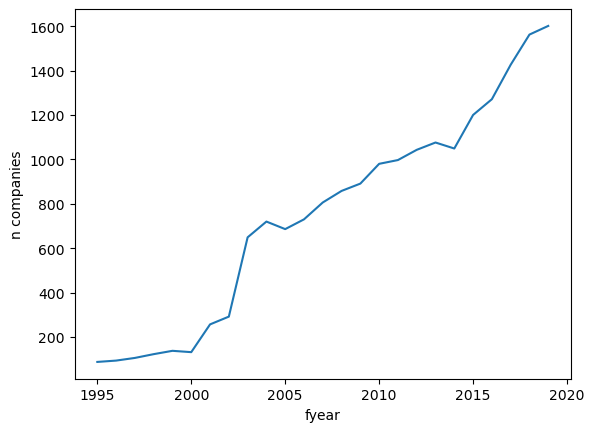

In [23]:
companies_per_year.plot(ylabel="n companies")

## years per company

In [24]:
years_per_company = df.groupby('company_name').fyear.nunique().sort_values()
years_per_company

company_name
KANSAS CITY LIFE INS CO          1
EQUITABLE HOLDINGS INC           1
PENNYMAC FINANCIAL SERVICES      1
EPR PROPERTIES                   1
PENNYMAC MORTGAGE INVEST TR      1
                                ..
PNC FINANCIAL SVCS GROUP INC    25
HELMERICH & PAYNE               25
MARSH & MCLENNAN COS            25
DOVER CORP                      25
UNION PACIFIC CORP              25
Name: fyear, Length: 1936, dtype: int64

<Axes: xlabel='Years', ylabel='n companies'>

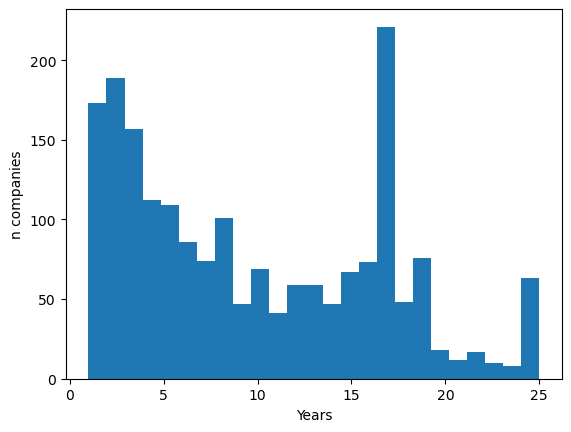

In [25]:
years_per_company.plot(kind="hist", bins=25, xlabel="Years", ylabel="n companies")

## staggered board?
### only staggered, never staggered, both

In [26]:
df_sbf = df.groupby('company_name')['sbf'].agg(set= lambda x: list(set(x)))
df_sbf

,set
company_name,
1-800-FLOWERS.COM,"[0, 1]"
1ST SOURCE CORP,[1]
2U INC,[1]
3D SYSTEMS CORP,[0]
8X8 INC,[0]
...,...
ZIONS BANCORPORATION NA,"[0, 1]"
ZOETIS INC,[1]
ZSCALER INC,[1]


[Text(0, 0, 'staggered'), Text(1, 0, 'not staggered'), Text(2, 0, 'both')]

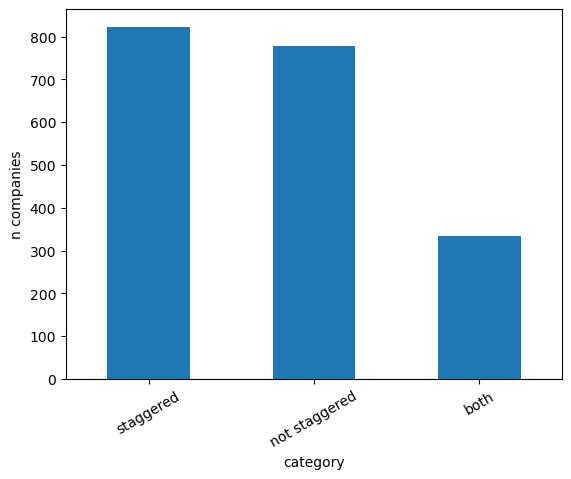

In [34]:
ax = df_sbf["set"].value_counts().plot(kind="bar", ylabel="n companies", xlabel="category", rot=30)
ax.set_xticklabels(["staggered", "not staggered", "both"])


## kld index per company

In [28]:
kld_per_company = df.groupby('company_name')["kld_index"].agg(mean="mean")
kld_per_company

,mean
company_name,
1-800-FLOWERS.COM,-0.066667
1ST SOURCE CORP,0.064986
2U INC,0.400000
3D SYSTEMS CORP,0.020833
8X8 INC,-0.143939
...,...
ZIONS BANCORPORATION NA,0.141975
ZOETIS INC,0.327466
ZSCALER INC,0.355556


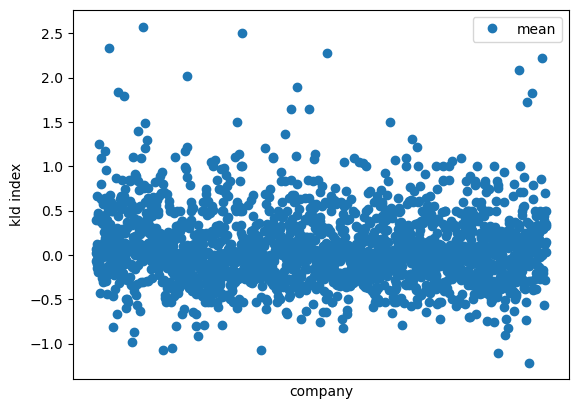

In [29]:
ax = kld_per_company.plot(kind="line", ylabel="kld index", xlabel="company", style='o')
ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False) 

## kld per sbf & company

In [30]:
kld_per_sbf_and_company = df.groupby(["company_name", "sbf"])["kld_index"].agg(mean="mean")
kld_per_sbf_and_company

mean
company_name            sbf          
1-800-FLOWERS.COM       0    0.333333
                        1   -0.152381
1ST SOURCE CORP         1    0.064986
2U INC                  1    0.400000
3D SYSTEMS CORP         0    0.020833
...                               ...
ZIONS BANCORPORATION NA 1   -0.068333
ZOETIS INC              1    0.327466
ZSCALER INC             1    0.355556
ZUMIEZ INC              1    0.033677
ZUORA INC               1    0.500000

[2270 rows x 1 columns]

[Text(1, 0, 'Staggered (1157 data points)'),
 Text(2, 0, 'Not Staggered (1113 data points)')]

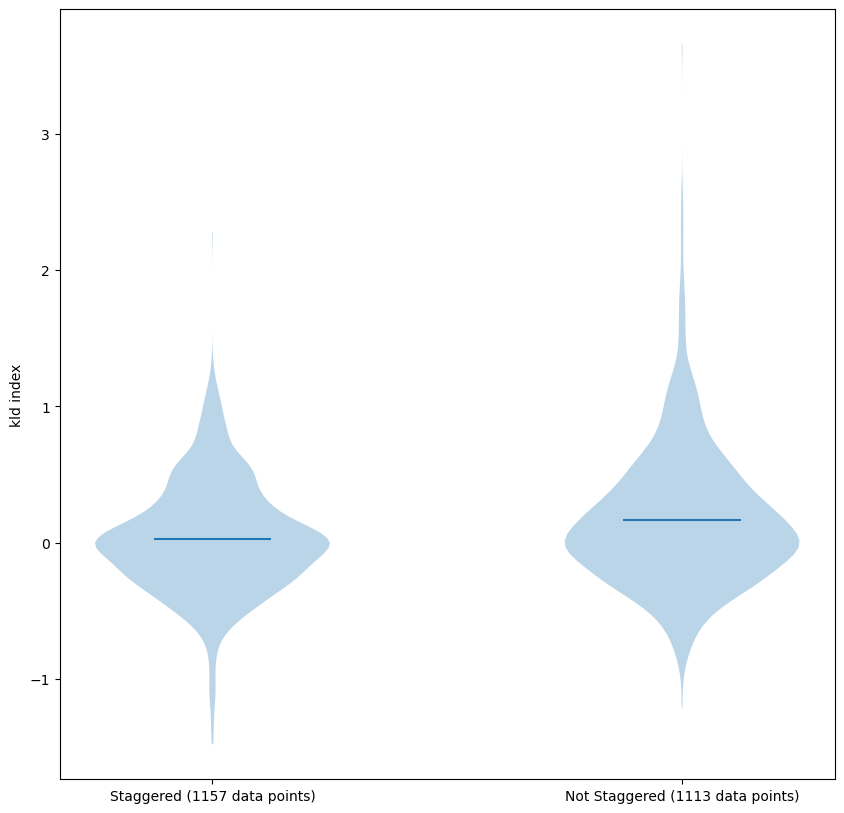

In [37]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=(10, 10))

kld_sbf = kld_per_sbf_and_company[kld_per_sbf_and_company.index.isin([1], level=1)].values.squeeze(1)
kld_no_sbf = kld_per_sbf_and_company[kld_per_sbf_and_company.index.isin([0], level=1)].values.squeeze(1)

axes.violinplot(dataset = [kld_sbf, kld_no_sbf], showextrema=False, showmeans=True)
axes.set_ylabel("kld index")
axes.set_xticks([1, 2])
axes.set_xticklabels(["Staggered (1157 data points)", "Not Staggered (1113 data points)"])